In [12]:
from briefcase.case import Case
from briefcase.case_base import CaseBase
from briefcase.enums import incons_enum
import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import TelcoConverter as TC
import random

historic_splits = [0.25, 0.5, 0.75, 0.95]

def test_constrainted_inconsistency(data_splits, constraint="ALL"):
    historic = data_splits['historic']
    new = data_splits['new']
    
    historic_cases = [Case.from_dict(c) for c in historic]
    cb = CaseBase(historic_cases)
    
    admitted = 0
    for item in new:
        new_case = Case.from_dict(item)
        # test without adding to case base
        if cb.order.admissibility_constraints.is_case_admissible(new_case.reason, new_case.defeated(), constraint):
            admitted += 1
            
    print(f"Number of cases admitted: {admitted}")
    size, inconsistencies = cb.metrics()
    return admitted, size, inconsistencies

def split_data(data):
    data_splits = {}
    for historic_split in historic_splits:
        historic = random.sample(data, k=int(historic_split * len(data)))
        # take 40 samples because max samples when 95% is 45
        new = random.sample(data, k=40)
        data_splits[historic_split] = {'historic': historic, 'new': new}
    return data_splits


In [13]:
# Initial Stats 
data = TC.get_existing_test_data()
initial_cases = [Case.from_dict(c) for c in data]
initial_cb = CaseBase(initial_cases)
initial_cb.metrics()
filtered_1perc_power = TC.filter_data_by_power(data, 1)

Loaded data successfully from 'data/telco-corr-test-0.75-False.yaml'
Number of cases:  4111
Number of cases associated with inconsistency:  3612
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9


## Admissibility experiments 
1. Split the data into a set of historic cases, and new cases 
2. Add each 

In [69]:
def experiment_perc_incons(data, repetitions=100):
    # Initialize results list
    results = []
    
    # Repeat the experiment
    for _ in range(repetitions):
        data_splits = split_data(data)
        
        for historic_split in historic_splits:
            for constraint in [incons_enum.NO, incons_enum.NO_NEW, incons_enum.NO_INVOLVEMENT, 
                               incons_enum.HORTY, incons_enum.NO_CORRUPTION, incons_enum.ALL]:
                print(f"\nHistoric Split: {historic_split}")
                print(f"Constraint: {constraint.name}")
                
                # Run the experiment
                admitted, cases_size, tainted_cases = test_constrainted_inconsistency(data_splits[historic_split], constraint=constraint)
                
                # Store the results
                results.append({'Historic Split': historic_split, 
                                'Constraint': constraint.name, 
                                'No. cases admitted': admitted,
                                "No. cases": cases_size,
                                "No. inconsistent cases": tainted_cases,
                                "No. total cases for admission": len(data_splits[historic_split]['new'])})
    
    # Convert results to DataFrame for easier manipulation
    results_df = pd.DataFrame(results)
    
    # Group by Historic Split and Constraint, calculate the average
    average_results = results_df.groupby(['Historic Split', 'Constraint']).mean().reset_index()
    
    plot_all(average_results, repetitions)
    no_new_involvement_no_corruption_plot(average_results, repetitions)
    return average_results

def no_new_involvement_no_corruption_plot(average_results, repetitions):
    # Calculate the percentage of new cases admitted
    average_results['Percentage new cases admitted'] = average_results['No. cases admitted'] / average_results['No. total cases for admission'] * 100
    
    average_results['Constraint'] = average_results['Constraint'].replace('HORTY', 'NO_NEW+NO_INVOLVEMENT')
    
    
    # Filter DataFrame for the constraints (B) and (C)
    filtered_df = average_results[average_results['Constraint'].isin(['NO_NEW+NO_INVOLVEMENT', 'NO_CORRUPTION'])]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    for constraint in filtered_df['Constraint'].unique():
        sub_df = filtered_df[filtered_df['Constraint'] == constraint]
        plt.plot(sub_df['Historic Split'], sub_df['Percentage new cases admitted'], label=constraint)
    
    plt.title(f"Average Percentage of New Cases Admitted with (B) NO_NEW+NO_INVOLVEMENT, and (C) NO_CORRUPTION admissibility constraints ({repetitions} trials)")
    plt.xlabel("Percentage cases in existing case base")
    plt.ylabel("Average percentage of new cases admitted")
    plt.grid(True)
    plt.show()

def plot_all(average_results, repetitions):
    # Plotting
    plt.figure(figsize=(10, 6))
    
    for constraint in average_results['Constraint'].unique():
        sub_df = average_results[average_results['Constraint'] == constraint]
        plt.plot(sub_df['Historic Split'], sub_df['No. cases admitted'], label=constraint)
    
    plt.title(f"Average Number of New Cases Admitted to a Case Base with all Admissibility Constraints - {repetitions} trials")
    plt.xlabel("Percentage cases in existing case base")
    plt.ylabel("Number of new cases admitted")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, None)  # y-axis starts at 0
    plt.show()


Historic Split: 0.25
Constraint: NO_INCONSISTENCY
Number of cases admitted: 0
Number of cases:  1028
Number of cases associated with inconsistency:  798
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: NO_NEW
Number of cases admitted: 25
Number of cases:  1028
Number of cases associated with inconsistency:  798
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: NO_INVOLVEMENT
Number of cases admitted: 18
Number of cases:  1028
Number of cases associated with inconsistency:  798
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: HORTY
Number of cases admitted: 39
Number of cases:  1028
Number of cases associated with inconsistency:  798
Maxim

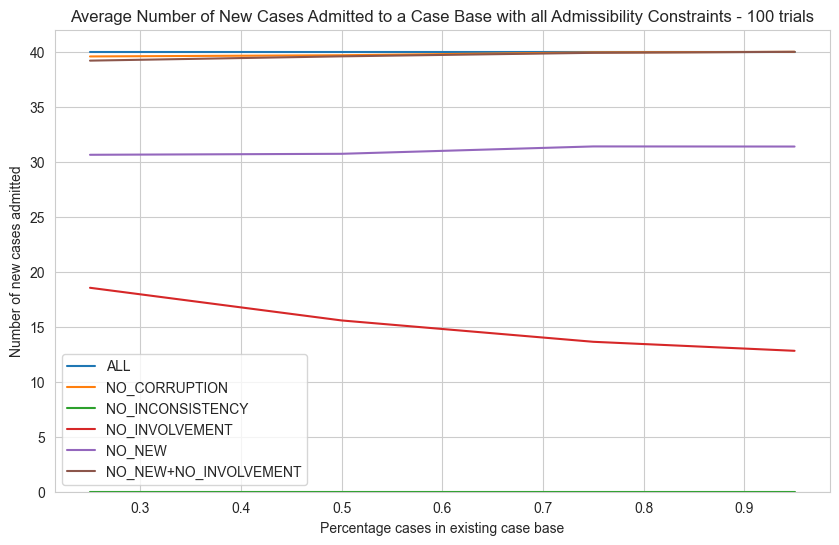

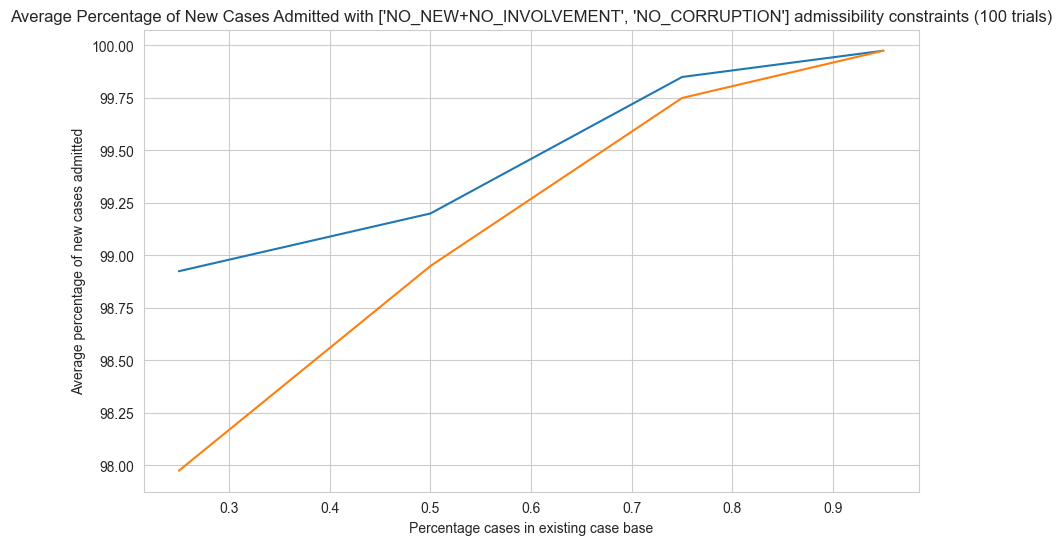

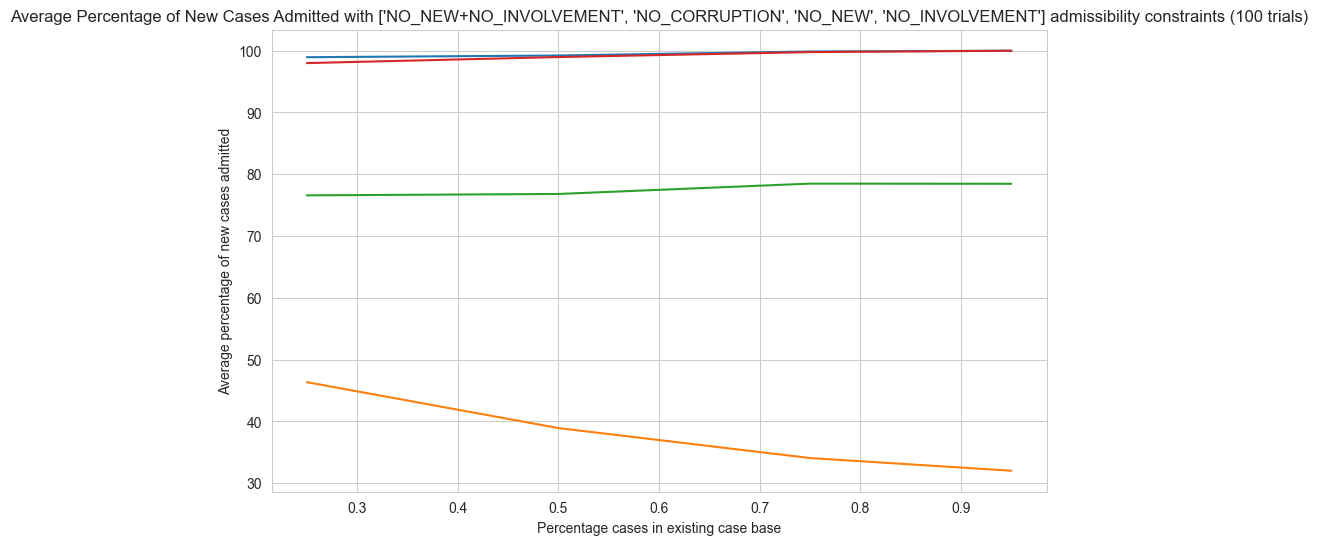

In [70]:
experiment_perc_incons(data, 50)

In [72]:
experiment_perc_incons(filtered_1perc_power, 50)
# lower power, any pair of cases smaller circle, more no involvement, less priority order thing

F_onewayResult(statistic=2999.8315312295767, pvalue=7.904287960840635e-272)


Historic Split: 0.25
Constraint: NO_INCONSISTENCY
Number of cases admitted: 0
Number of cases:  726
Number of cases associated with inconsistency:  93
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: NO_NEW
Number of cases admitted: 25
Number of cases:  726
Number of cases associated with inconsistency:  93
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: NO_INVOLVEMENT
Number of cases admitted: 36
Number of cases:  726
Number of cases associated with inconsistency:  93
Maximum number of edges on a pi case: 261632
Maximum number of edges on a delta case: 261888
Factors for pi: 10
Factors for delta: 9

Historic Split: 0.25
Constraint: HORTY
Number of cases admitted: 38
Number of cases:  726
Number of cases associated with inconsistency:  93
Maximum numbe

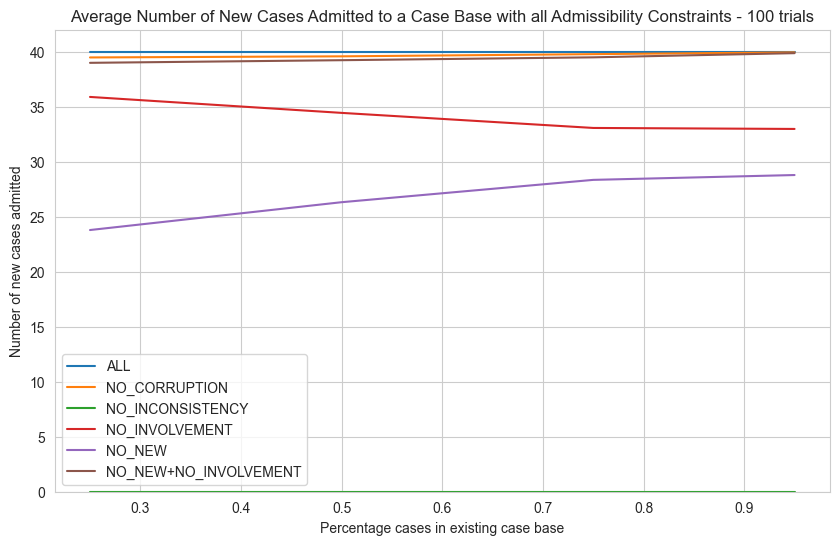

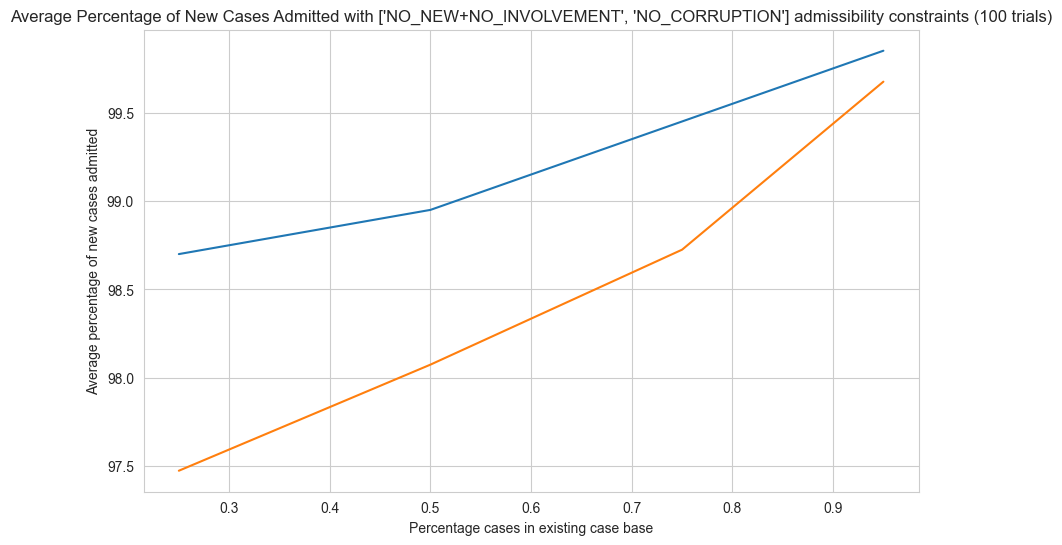

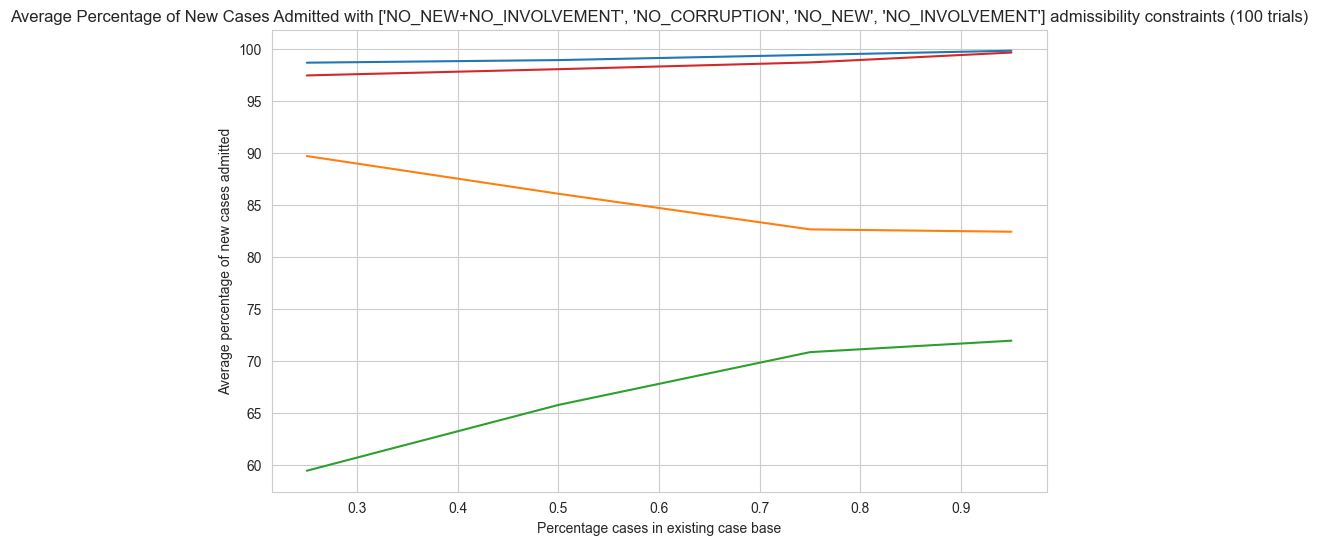

In [74]:
# 